In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

from CIFAR100_helper import *
from model import *
from common import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

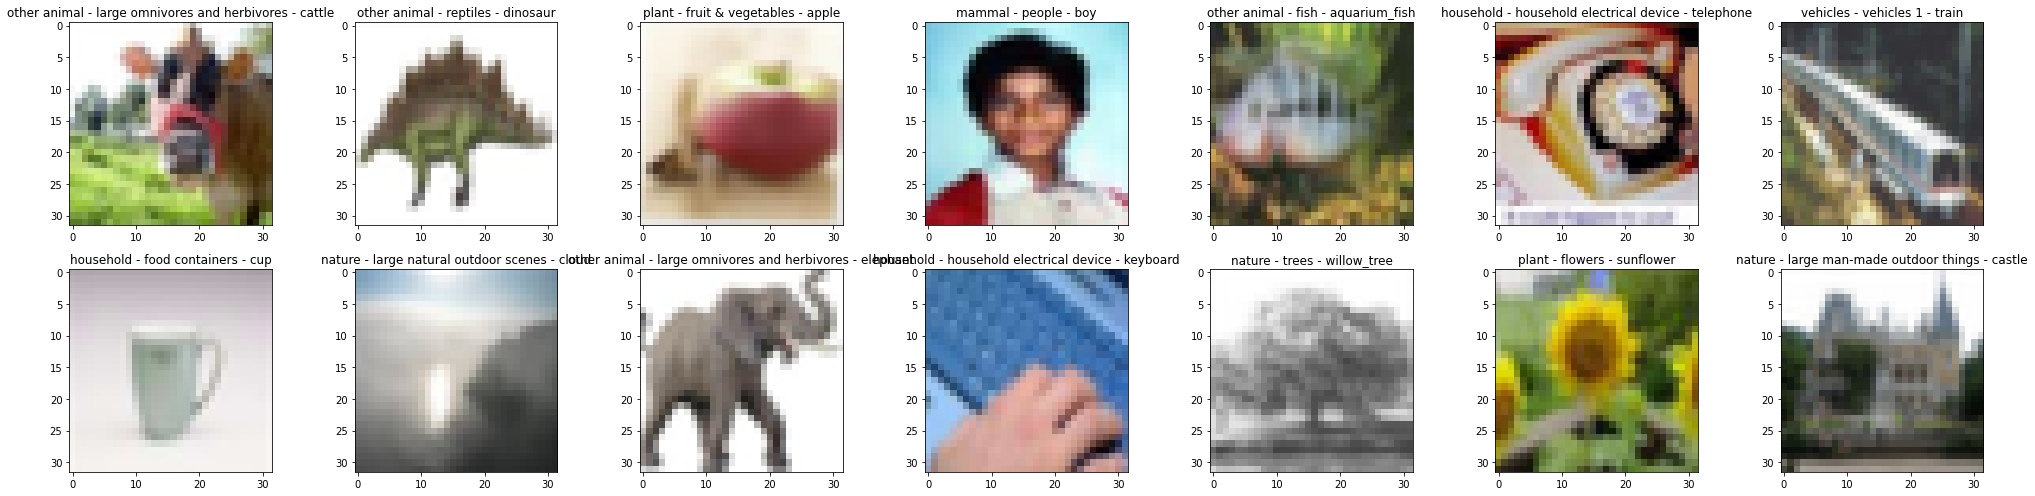

In [3]:
X, Y_ultra, Y_super, Y_sub = get_cifar100()
plot_sample_images((X, Y_ultra, Y_super, Y_sub), v_get_labels)

In [4]:
def create_layer(img_input, n_classes, fc_dropout=0.3, activation='relu', class_type = 'default', embedding = None, nodes = 64):
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(img_input)
#     x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2', enable_dropout=False)(x)
    if embedding is not None:
        x = tf.keras.layers.Concatenate()([x, embedding])
    output = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    return output, x

In [5]:
def create_model(plot=False):
    n_ultraclasses = 7
    n_superclasses = 20
    n_subclasses = 100
    input_shape = x_train[0].shape

    img_input = Input(shape=input_shape, name='input')

    base_layer = vgg13(img_input, conv_dropout=0.3, class_type = 'base')
    base_layer = Dropout(0.5)(base_layer)
    
    ultra_layer, ultra_layer_embedding = create_layer(base_layer, n_ultraclasses, class_type = 'ultra')
    super_layer, super_layer_embedding = create_layer(base_layer, n_superclasses, class_type = 'super', embedding = ultra_layer_embedding)
    sub_layer,_ = create_layer(base_layer, n_subclasses, class_type = 'sub', embedding = super_layer_embedding)

    model = keras.Model(inputs=img_input,
                 outputs = [ultra_layer, super_layer, sub_layer],
                 name="cifar100")
    if plot:
        fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=75)
        display(fig)
        
    init_lr = 5e-4
    lr_decay = 1e-6

    opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

    model.compile(
        optimizer=opt,
        loss={
            'ultra_output':'categorical_crossentropy',
            'super_output':'categorical_crossentropy',
            'sub_output':'categorical_crossentropy'
        },
         metrics={
            'ultra_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_ultraclasses / 10) if int(n_ultraclasses / 10) > 2 else 2)],
            'super_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_superclasses / 10) if int(n_superclasses / 10) > 2 else 2)],
            'sub_output':['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=int(n_subclasses / 10) if int(n_subclasses / 10) > 2 else 2)]
        },
        loss_weights=[0.2, 0.35, 0.45]
    )
    
    return model

Training on fold 1/5...


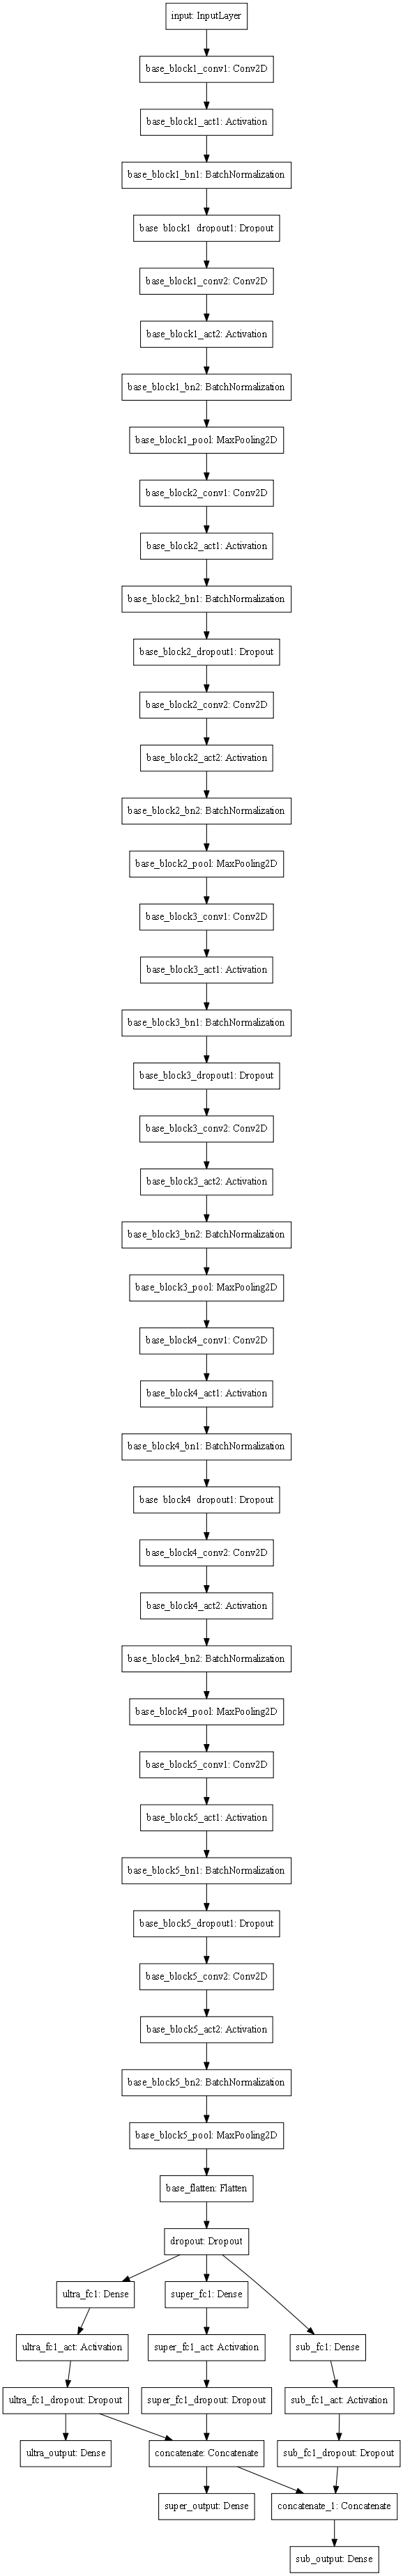

Epoch 1/100
150/150 [==============================] - 16s 77ms/step - loss: 3.9048 - ultra_output_loss: 2.1436 - super_output_loss: 3.3515 - sub_output_loss: 5.1180 - ultra_output_accuracy: 0.2564 - ultra_output_top_k_categorical_accuracy: 0.4437 - super_output_accuracy: 0.1027 - super_output_top_k_categorical_accuracy: 0.1889 - sub_output_accuracy: 0.0256 - sub_output_top_k_categorical_accuracy: 0.1866 - val_loss: 3.9747 - val_ultra_output_loss: 2.1858 - val_super_output_loss: 3.4423 - val_sub_output_loss: 5.1839 - val_ultra_output_accuracy: 0.2018 - val_ultra_output_top_k_categorical_accuracy: 0.3998 - val_super_output_accuracy: 0.0469 - val_super_output_top_k_categorical_accuracy: 0.1027 - val_sub_output_accuracy: 0.0114 - val_sub_output_top_k_categorical_accuracy: 0.0972
Epoch 2/100
150/150 [==============================] - 10s 65ms/step - loss: 2.9472 - ultra_output_loss: 1.5497 - super_output_loss: 2.4771 - sub_output_loss: 3.9339 - ultra_output_accuracy: 0.4002 - ultra_output_

In [6]:
stats =[]
n_splits = 5
epochs = 100
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, np.argmax(Y_sub, axis=1))):
    print (f"Training on fold {index + 1}/{n_splits}...")
    x_train, y_ultra_train, y_super_train, y_sub_train = X[train_indices], Y_ultra[train_indices], Y_super[train_indices], Y_sub[train_indices]
    x_test, y_ultra_test, y_super_test, y_sub_test = X[val_indices], Y_ultra[val_indices], Y_super[val_indices], Y_sub[val_indices]
    model = None
    model = create_model(True if index == 0 else False)
    stats.append(train_and_predict(model, epochs, (x_train, y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test)))
    reset_keras(model)

In [7]:
for i, stat in enumerate(stats):
    print(f"Fold {i + 1}: {stat}")

print("\n\nAverage [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:")
for i in range(len(stats[0])):
    print(sum([x[i] for x in stats]) / len(stats))

Fold 1: (0.3100833333333333, 0.4449166666666667, 0.061111111111111116)
Fold 2: (0.31716666666666665, 0.44875, 0.06283333333333334)
Fold 3: (0.30783333333333335, 0.44316666666666665, 0.05919444444444444)
Fold 4: (0.33425, 0.4686666666666667, 0.058666666666666666)
Fold 5: (0.29825, 0.4355833333333333, 0.05913888888888889)


Average [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:
0.31351666666666667
0.4482166666666666
0.06018888888888889
